# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [54]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 8

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


In [ ]:
# ==============================================================================
# Code from here. Best of luckk :)
# ==============================================================================

In [55]:
# Training and validation of sample

import matplotlib.pyplot as plt

n_total = X_full.shape[0]
cut = int(0.7 * n_total)

X_train = X_full[:cut]
y_train = y_full[:cut]

X_val = X_full[cut:]
y_val = y_full[cut:]

print("Train samples:", X_train.shape[0], "Val samples:", X_val.shape[0])

Train samples: 2100 Val samples: 900


In [56]:
# Initialization

# architecture 2 -> 16 -> 16 -> 16 -> 1
w1 = torch.randn(2, 16) * 0.01
b1 = torch.zeros(1, 16)
w2 = torch.randn(16, 16) * 0.01
b2 = torch.zeros(1, 16)
w3 = torch.randn(16, 16) * 0.01
b3 = torch.zeros(1, 16)
w4 = torch.randn(16, 1) * 0.01
b4 = torch.zeros(1, 1)

# make sure grads are tracked
w1.requires_grad_()
b1.requires_grad_()
w2.requires_grad_()
b2.requires_grad_()
w3.requires_grad_()
b3.requires_grad_()
w4.requires_grad_()
b4.requires_grad_()

print("Weights and biases created.")


Weights and biases created.


In [57]:
# Activation

def relu(x):
    # vectorized but simple
    return x * (x > 0).float()

def sigmoid(x):
    return 1.0 / (1.0 + torch.exp(-x))

In [58]:
# binary cross-entropy

def bce(y_true, y_pred):
    # y_true and y_pred are (N,1)
    loss = - (y_true * torch.log(y_pred) + (1 - y_true) * torch.log(1 - y_pred))
    return loss.mean()

In [59]:
# Forward function

def net(X):
    z1 = X @ w1 + b1    # (N,16)
    a1 = relu(z1)
    z2 = a1 @ w2 + b2
    a2 = relu(z2)
    z3 = a2 @ w3 + b3
    a3 = relu(z3)
    z4 = a3 @ w4 + b4
    out = sigmoid(z4)   # (N,1)
    return out

In [60]:
lr = 0.01
epochs = 1500

train_losses = []
val_losses = []

for epoch in range(epochs + 1):
    # Forward pass
    z1 = X_train @ w1 + b1
    a1 = z1 * (z1 > 0).float()

    z2 = a1 @ w2 + b2
    a2 = z2 * (z2 > 0).float()

    z3 = a2 @ w3 + b3
    a3 = z3 * (z3 > 0).float()

    z4 = a3 @ w4 + b4
    y_pred = 1 / (1 + torch.exp(-z4))

    # Loss (BCE)
    loss = -torch.mean(y_train * torch.log(y_pred + 1e-7) + (1 - y_train) * torch.log(1 - y_pred + 1e-7))
    train_losses.append(loss.item())

    # Backward
    loss.backward()

    for p in [w1, b1, w2, b2, w3, b3, w4, b4]:
        p.data -= lr * p.grad.data
        p.grad.data.zero_()

    # Validation
    z1v = X_val @ w1 + b1
    a1v = z1v * (z1v > 0).float()
    z2v = a1v @ w2 + b2
    a2v = z2v * (z2v > 0).float()
    z3v = a2v @ w3 + b3
    a3v = z3v * (z3v > 0).float()
    z4v = a3v @ w4 + b4
    y_val_pred = 1 / (1 + torch.exp(-z4v))
    val_loss = -torch.mean(y_val * torch.log(y_val_pred + 1e-7) + (1 - y_val) * torch.log(1 - y_val_pred + 1e-7))
    val_losses.append(val_loss.item())

    if epoch % 500 == 0 or epoch == epochs:
        print(f"Epoch {epoch} | Train Loss: {loss.item():.4f} | Val Loss: {val_loss.item():.4f}")

Epoch 0 | Train Loss: 0.6931 | Val Loss: 0.6930
Epoch 500 | Train Loss: 0.6727 | Val Loss: 0.6723
Epoch 1000 | Train Loss: 0.6710 | Val Loss: 0.6704
Epoch 1500 | Train Loss: 0.6708 | Val Loss: 0.6703


In [61]:
# Accuracy function

def accuracy(X, y):
    yhat = net(X)
    preds = (yhat > 0.5).float()
    return (preds == y).float().mean().item()

print("Final Train acc:", accuracy(X_train, y_train))
print("Final Validation acc:  ", accuracy(X_val, y_val))

Final Train acc: 0.6052380800247192
Final Validation acc:   0.6066666841506958


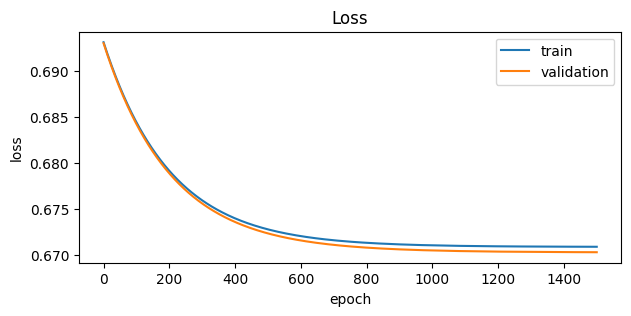

In [62]:
# Plotting

plt.figure(figsize=(7,3))
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('Loss')
plt.show()